In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import itertools
from collections import Counter
import numpy as np
%matplotlib inline


In [2]:
class RBM(nn.Module):
    def __init__(self, n_v, n_h):
        super(RBM, self).__init__()
        self.n_v = n_v
        self.n_h = n_h
        self.b_v = nn.Parameter(torch.randn(1, n_v))
        self.b_h = nn.Parameter(torch.randn(1, n_h))
        self.W = nn.Parameter(torch.randn(n_h, n_v))
        self.all_combinations = torch.tensor(list(itertools.product([0, 1], repeat=n_v+n_h)), dtype=torch.float32)
        self.v_combinations = torch.tensor(list(itertools.product([0, 1], repeat=n_v)), dtype=torch.float32)
        self.h_combinations = torch.tensor(list(itertools.product([0, 1], repeat=n_h)), dtype=torch.float32)
        self.z = nn.Parameter(self.Z())
        
    def v_to_h(self, v):
        if v.dim() == 1:
            v = v.unsqueeze(0)
        p = torch.sigmoid(F.linear(v, self.W, self.b_h))
        return torch.bernoulli(p)
    
    def h_to_v(self, h):
        if h.dim() == 1:
            h = h.unsqueeze(0)
        p = torch.sigmoid(F.linear(h, self.W.t(), self.b_v))
        return torch.bernoulli(p)
    
    def forward(self, v):
        h = self.v_to_h(v)
        v = self.h_to_v(h)
        return v
    
    def energy(self, v, h):
        if h.dim() == 1:
            h = h.unsqueeze(0)
        if v.dim() == 1:
            v = v.unsqueeze(0)
        vbias_term = torch.matmul(v, self.b_v.t())
        hbias_term = torch.matmul(h, self.b_h.t())
        weight_term = torch.matmul(torch.matmul(v, self.W.t()), h.t())
        return -(vbias_term + hbias_term + weight_term)
    
    def P_v(self, v):
        if v.dim() == 1:
            v = v.unsqueeze(0)
        p_v = 0
        for h in self.h_combinations:
            if h.dim() == 1:
                h = h.unsqueeze(0)
            p_v += torch.exp(-self.energy(v, h))
        p_v /= self.z
        return p_v
    
    def P_v_given_h(self, v, h):
        if h.dim() == 1:
            h = h.unsqueeze(0)
        if v.dim() == 1:
            v = v.unsqueeze(0)
        p_v_given_h = 1
        for j in range (self.n_v):
            if(v[0,j]==1):
                p_v_given_h *= self.P_vl_1_given_h(h, j)
            else:
                p_v_given_h *= 1 - self.P_vl_1_given_h(h, j)
        return p_v_given_h
                
    def P_vl_1_given_h(self, h, l):
    # Ensure h is a 2D tensor with shape [1, n_h]
        if h.dim() == 1:
            h = h.unsqueeze(0)
        weight = self.W[:, l].unsqueeze(0)
        return torch.sigmoid(F.linear(h, weight.t(), self.b_v[0,l]))
    
    def P_hl_1_given_v(self, v, l):
        if v.dim() == 1:
            v = v.unsqueeze(0)
        weight = self.W[l,:].unsqueeze(0)
        return torch.sigmoid(F.linear(v, weight, self.b_h[0,l]))
    
    def P_h_1_given_v(self, v):
        p_h_1_given_v = torch.zeros(self.n_h, 1)

        for i in range(self.n_h):
            p_h_1_given_v[i, 0] = self.P_hl_1_given_v(v, i)

        return p_h_1_given_v

    
    def Z(self):
        z = 0
        for v in self.v_combinations:
            for h in self.h_combinations:  
                z += torch.exp(-self.energy(v, h))
        return z
    
    def kl_loss(self, target_distribution):
        q = {tuple(k.tolist()): v for k, v in target_distribution.items()}
        dict = {}
        for v in self.v_combinations:
            p = self.P_v(v).item()  # Assuming P_v returns a tensor
            dict[tuple(v.tolist())] = p
        kl_div = 0
        for v, p in dict.items():
            p_t = q.get(v, 0)
            if p_t > 0:
                kl_div += p_t * np.log(p_t / p)

        return kl_div
    
    def RBM_dist(self):
        dict = {}
        for v in self.v_combinations:
            p = self.P_v(v).item()  # Assuming P_v returns a tensor
            dict[v] = p
        return dict
    
    def Gibbs_sampler(self, N, Burn_N):
        total_samples = N + Burn_N  # Total samples including burn-in
        samples = torch.empty((total_samples, self.n_v))

        # Initial sample
        sample_init = torch.bernoulli(torch.full((self.n_v,), 0.5))
        samples[0] = sample_init

        # Generate samples
        for i in range(total_samples - 1):
            samples[i + 1] = self.forward(samples[i])

        # Discard the first Burn_N samples
        return samples[Burn_N:]

In [3]:
def plot_histograms(rbm_dist, empirical_dist):
    # Prepare the data for plotting
    rbm_data_points = [str(k.numpy()) for k in rbm_dist.keys()]
    rbm_probabilities = list(rbm_dist.values())

    empirical_data_points = [str(k.numpy()) for k in empirical_dist.keys()]
    empirical_probabilities = list(empirical_dist.values())

    # Ensure the data points are in the same order for both distributions
    all_data_points = list(set(rbm_data_points + empirical_data_points))
    all_data_points.sort()
    index_map = {data_point: index for index, data_point in enumerate(all_data_points)}

    rbm_indices = [index_map[point] for point in rbm_data_points]
    empirical_indices = [index_map[point] for point in empirical_data_points]

    # Determine the number of bins for the histogram
    n_bins = len(all_data_points)

    # Plotting
    plt.figure(figsize=(12, 6))

    # Plot RBM histogram
    plt.bar(rbm_indices, rbm_probabilities, width=0.4, label='RBM Distribution', alpha=0.7)

    # Plot Empirical histogram
    plt.bar(empirical_indices, empirical_probabilities, width=0.4, label='Empirical Distribution', alpha=0.7, color='red')

    plt.xticks(ticks=range(n_bins), labels=all_data_points, rotation=90)  # Set custom x-axis tick labels
    plt.xlabel('Data Point')
    plt.ylabel('Probability')
    plt.title('Comparison of RBM and Empirical Distributions')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()  # Adjust layout for better fit
    plt.show()
    
def empirical_distribution(tensor_data):
    # Convert the tensor to a numpy array and then to a list of tuples
    numpy_data = tensor_data.detach().numpy()
    flattened_data = [tuple(row) for row in numpy_data]

    # Count the frequency of each unique data point
    freq = Counter(flattened_data)

    # Calculate the total number of data points
    total = sum(freq.values())

    # Calculate the relative frequency (empirical probability) of each data point
    empirical_dist = {torch.tensor(k, dtype=torch.float32): v / total for k, v in freq.items()}

    return empirical_dist

## Test
Generate a 4 visiable 4 hidden RBM by the defined class to test the training loop.

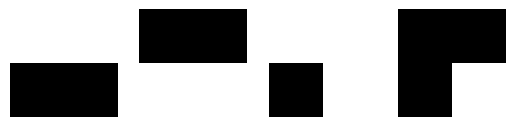

[[0 0 1 1]
 [1 1 0 0]
 [0 0 1 0]
 [1 1 1 0]]
20
0.9999999161809683
Parameter containing:
tensor([[98.0502]], requires_grad=True)


In [29]:
def generate_shapes():
    data = []

    # Horizontal line
    data.append(np.array([
        [0, 0],
        [1, 1],
    ]))

    # Vertical line
    data.append(np.array([
        [1, 1],
        [0, 0],
    ]))

    # Small square
    data.append(np.array([
        [0, 0],
        [1, 0],
    ]))

    # Diagonal line
    data.append(np.array([
        [1, 1],
        [1, 0],
    ]))

    return data

data = generate_shapes()

# Display the shapes
for i, shape in enumerate(data):
    plt.subplot(1, len(data), i+1)
    plt.imshow(shape, cmap='binary')
    plt.axis('off')
plt.show()

data = np.array(data).reshape(-1, 4)
tensor_data = torch.tensor(data, dtype=torch.float32)
print(data)

v_size = 4
h_size = 3

rbm = RBM(v_size, h_size)
rbm1 = rbm

total_params = sum(p.numel() for p in rbm.parameters())
print(total_params)
print(sum(rbm.RBM_dist().values()))
print(rbm.z)



Data Point: tensor([0., 0., 1., 1.]), Probability: 0.25
Data Point: tensor([1., 1., 0., 0.]), Probability: 0.25
Data Point: tensor([0., 0., 1., 0.]), Probability: 0.25
Data Point: tensor([1., 1., 1., 0.]), Probability: 0.25


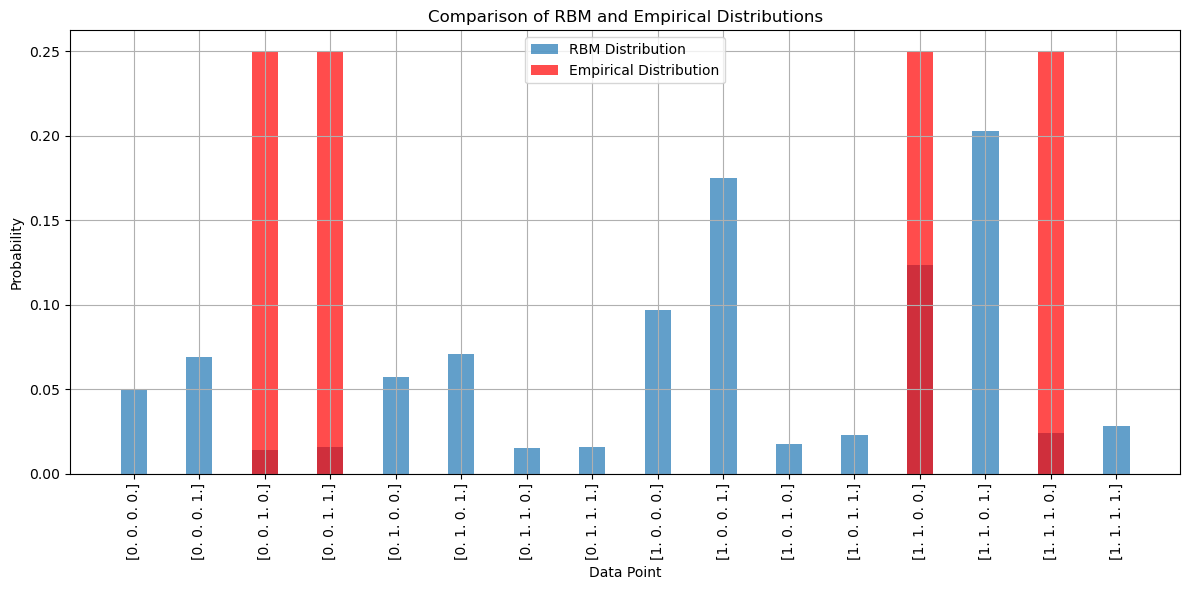

In [30]:

dist = empirical_distribution(tensor_data)

# Print the empirical distribution
for k, v in dist.items():
    print(f"Data Point: {k}, Probability: {v}")

RBM_distribution1 = rbm1.RBM_dist()   
plot_histograms(RBM_distribution1, dist)

In [31]:

epoch = 500
lr = 0.5
n_data = 4
loss_values = []
for k in range(epoch):
    g_W = torch.randn(h_size, v_size)
    g_b_v = torch.randn(1, v_size)
    g_b_h = torch.randn(1, h_size)
    Z = rbm.Z()
    
    for l in range(n_data):
        v = torch.tensor(data[l,:], dtype=torch.float32)
        v = v.unsqueeze(0)
        h = rbm.v_to_h(v)
        
        sector_1 = 0
        sector_2 = 0
        sector_3 = 0
        for vv in rbm.v_combinations:
            vv = vv.unsqueeze(0)
            p_v = rbm.P_v(vv)
            p_h_given_v = rbm.P_h_1_given_v(vv)
            product = p_v * p_h_given_v
            sector_1 += torch.matmul(product, vv)

            sector_2 += rbm.P_v(vv) * vv 
            
            sector_3 += rbm.P_v(vv) * rbm.P_h_1_given_v(vv).t()
            
        g_W += torch.matmul(rbm.P_h_1_given_v(v), v) - sector_1
        g_b_v += v - sector_2
        g_b_h += rbm.P_h_1_given_v(v).t() - sector_3
        
    g_W = g_W/n_data
    g_b_v = g_b_v/n_data
    g_b_h = g_b_h/n_data
    
    rbm.W = nn.Parameter(rbm.W + lr * g_W)
    rbm.b_v = nn.Parameter(rbm.b_v + lr * g_b_v)
    rbm.b_h = nn.Parameter(rbm.b_h + lr * g_b_h)
    rbm.z = nn.Parameter(rbm.Z())
    loss = rbm.kl_loss(dist)
    loss_values.append(loss.item())
    if ((k+1)%50==0):

        print(f'epoch {k+1}, loss {loss}')
    

epoch 50, loss 0.5565392059989629
epoch 100, loss 0.19272045230064577
epoch 150, loss 0.20081320052366616
epoch 200, loss 0.10558542445138618
epoch 250, loss 0.09718831047356428
epoch 300, loss 0.11991384592251857
epoch 350, loss 0.06344295662198163
epoch 400, loss 0.08942596194789865
epoch 450, loss 0.11830017424542784
epoch 500, loss 0.07245545938764314


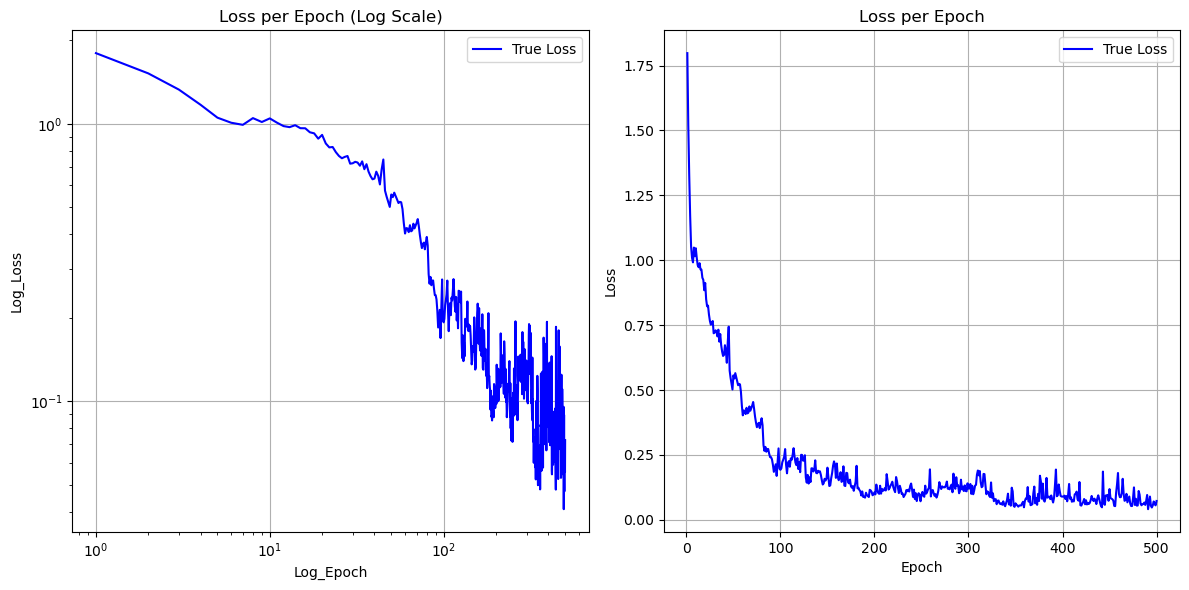

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# First subplot with log scale for both axes
axs[0].plot(range(1, epoch + 1), loss_values, label='True Loss', color='blue')
axs[0].set_xlabel('Log_Epoch')
axs[0].set_ylabel('Log_Loss')
axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].set_title('Loss per Epoch (Log Scale)')
axs[0].legend()
axs[0].grid(True)

# Second subplot with linear scale (default)
axs[1].plot(range(1, epoch + 1), loss_values, label='True Loss', color='blue')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Loss per Epoch')
axs[1].legend()
axs[1].grid(True)

# Display the plot
plt.tight_layout()  # Adjust subplots to fit into the figure area.
plt.show()

pattern tensor([0., 0., 0., 0.]) has the probability 0.0002272768906550482
pattern tensor([0., 0., 0., 1.]) has the probability 8.4075698396191e-05
pattern tensor([0., 0., 1., 0.]) has the probability 0.18610434234142303
pattern tensor([0., 0., 1., 1.]) has the probability 0.22831639647483826
pattern tensor([0., 1., 0., 0.]) has the probability 0.005553578957915306
pattern tensor([0., 1., 0., 1.]) has the probability 2.6723242626758292e-05
pattern tensor([0., 1., 1., 0.]) has the probability 0.029691314324736595
pattern tensor([0., 1., 1., 1.]) has the probability 0.0020959218963980675
pattern tensor([1., 0., 0., 0.]) has the probability 0.002267230534926057
pattern tensor([1., 0., 0., 1.]) has the probability 1.0342387213313486e-05
pattern tensor([1., 0., 1., 0.]) has the probability 0.004565260373055935
pattern tensor([1., 0., 1., 1.]) has the probability 0.0005192418466322124
pattern tensor([1., 1., 0., 0.]) has the probability 0.20815101265907288
pattern tensor([1., 1., 0., 1.]) ha

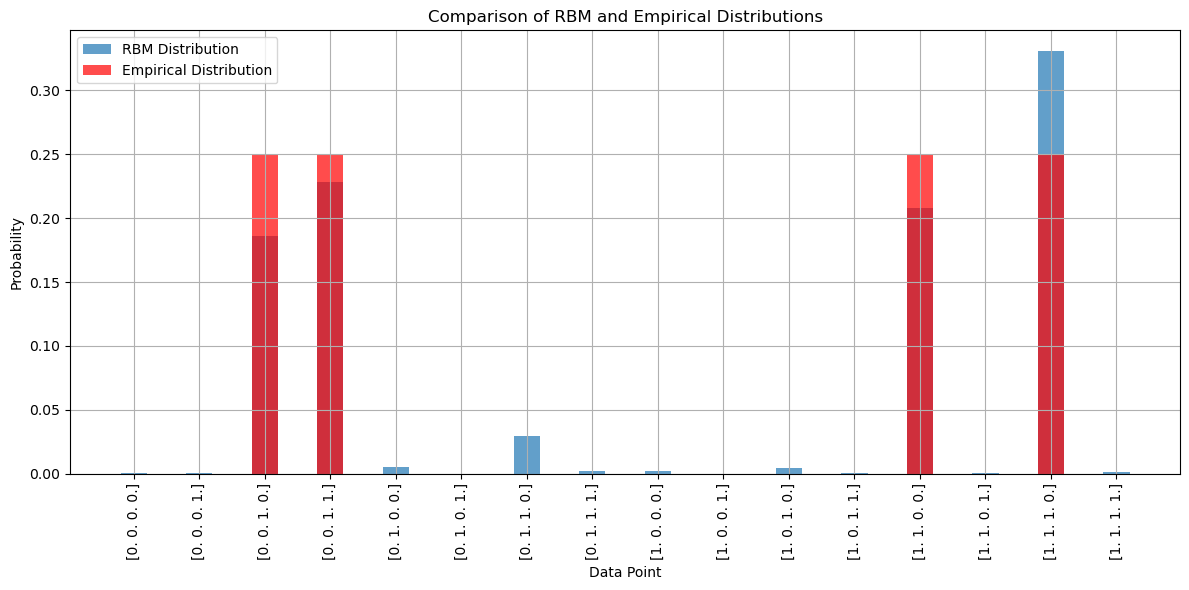

In [34]:
RBM_distribution = rbm.RBM_dist()
for k, v in RBM_distribution.items():
    print(f'pattern {k} has the probability {v}')
plot_histograms(RBM_distribution, dist)

In [7]:
rbm2 = RBM(n_v=4, n_h=3)

In [8]:
num_sample = 1000
burn_down = 1000

data = rbm2.Gibbs_sampler(num_sample, burn_down)
tensor_data = torch.tensor(data, dtype=torch.float32)


/var/folders/3n/sd9mh6rx2h5byl5f0955mv840000gn/T/ipykernel_29929/3461281460.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_data = torch.tensor(data, dtype=torch.float32)


In [9]:
def plot_histograms_sample(rbm_dist, empirical_dist):
    rbm_data_points = [str(k.numpy()) for k in rbm_dist.keys()]
    rbm_probabilities = list(rbm_dist.values())
    empirical_data_points = [str(k.numpy()) for k in empirical_dist.keys()]
    empirical_probabilities = list(empirical_dist.values())
    all_data_points = list(set(rbm_data_points + empirical_data_points))
    all_data_points.sort()
    index_map = {data_point: index for index, data_point in enumerate(all_data_points)}
    rbm_indices = [index_map[point] for point in rbm_data_points]
    empirical_indices = [index_map[point] for point in empirical_data_points]
    n_bins = len(all_data_points)

    plt.figure(figsize=(12, 6))
    plt.bar(rbm_indices, rbm_probabilities, width=0.4, label='Target Distribution', alpha=0.7, color = 'blue')
    plt.bar(empirical_indices, empirical_probabilities, width=0.4, label='Sample Distribution', alpha=0.7, color='yellow')
    plt.xticks(ticks=range(n_bins), labels=all_data_points, rotation=90)  # Set custom x-axis tick labels
    plt.xlabel('Data Point')
    plt.ylabel('Probability')
    plt.title('Sample distribution')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()  # Adjust layout for better fit
    plt.show()

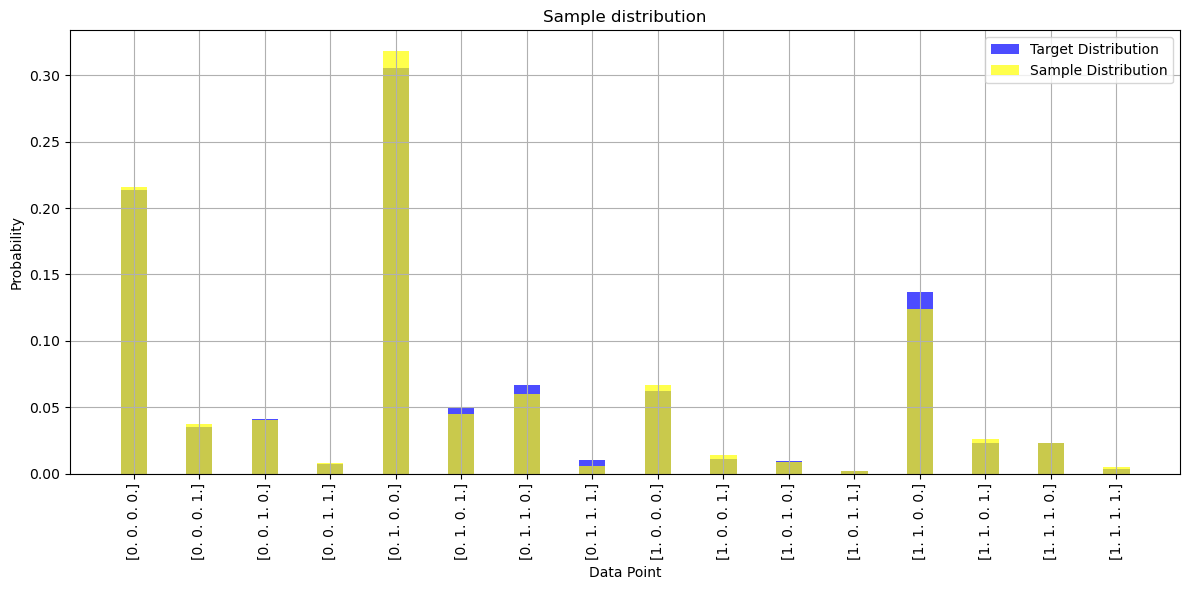

0.0036788364711869146

In [10]:
dist =  rbm2.RBM_dist()
sample_dist = empirical_distribution(tensor_data)
plot_histograms_sample(dist, sample_dist)
rbm2.kl_loss(sample_dist)

In [13]:
rbm3 = RBM(n_v=4, n_h=3)
rbm4 = rbm3

In [5]:
rbm5 = rbm3

In [6]:
def plot_histograms1(rbm_dist, empirical_dist):
    rbm_data_points = [str(k.numpy()) for k in rbm_dist.keys()]
    rbm_probabilities = list(rbm_dist.values())
    empirical_data_points = [str(k.numpy()) for k in empirical_dist.keys()]
    empirical_probabilities = list(empirical_dist.values())
    all_data_points = list(set(rbm_data_points + empirical_data_points))
    all_data_points.sort()
    index_map = {data_point: index for index, data_point in enumerate(all_data_points)}
    rbm_indices = [index_map[point] for point in rbm_data_points]
    empirical_indices = [index_map[point] for point in empirical_data_points]
    n_bins = len(all_data_points)

    plt.figure(figsize=(12, 6))
    plt.bar(empirical_indices, empirical_probabilities, width=0.4, label='Target Distribution', alpha=0.7, color='blue')
    plt.bar(rbm_indices, rbm_probabilities, width=0.4, label='RBM distribution', alpha=0.7, color = 'red')

    plt.xticks(ticks=range(n_bins), labels=all_data_points, rotation=90)  # Set custom x-axis tick labels
    plt.xlabel('Data Point')
    plt.ylabel('Probability')
    plt.title('Sample distribution')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()  # Adjust layout for better fit
    plt.show()

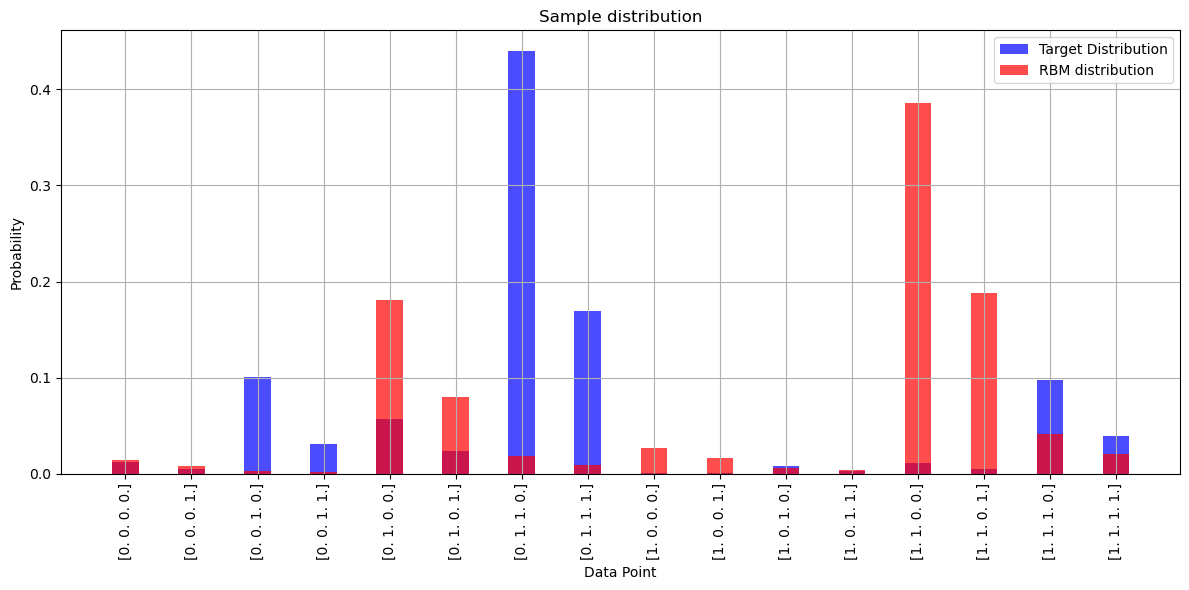

In [121]:
dist3 = rbm3.RBM_dist()
plot_histograms1(dist3, dist)

In [122]:
rbm = rbm3
epoch = 500
lr = 0.5
n_data = num_sample
min_true_loss = float('inf')  # Initialize minimum true loss to infinity
true_loss_values = []
empirical_loss_values = []

for k in range(epoch):
    g_W = torch.randn(h_size, v_size)
    g_b_v = torch.randn(1, v_size)
    g_b_h = torch.randn(1, h_size)
    Z = rbm.Z()
    
    for l in range(n_data):
        v = torch.tensor(data[l,:], dtype=torch.float32)
        v = v.unsqueeze(0)
        h = rbm.v_to_h(v)
        sector_1 = 0
        sector_2 = 0
        sector_3 = 0
        for vv in rbm.v_combinations:
            vv = vv.unsqueeze(0)
            p_v = rbm.P_v(vv)
            p_h_given_v = rbm.P_h_1_given_v(vv)
            product = p_v * p_h_given_v
            sector_1 += torch.matmul(product, vv)

            sector_2 += rbm.P_v(vv) * vv 
            
            sector_3 += rbm.P_v(vv) * rbm.P_h_1_given_v(vv).t()
            
        g_W += torch.matmul(rbm.P_h_1_given_v(v), v) - sector_1
        g_b_v += v - sector_2
        g_b_h += rbm.P_h_1_given_v(v).t() - sector_3
        
    g_W = g_W/n_data
    g_b_v = g_b_v/n_data
    g_b_h = g_b_h/n_data
    
    rbm.W = nn.Parameter(rbm.W + lr * g_W)
    rbm.b_v = nn.Parameter(rbm.b_v + lr * g_b_v)
    rbm.b_h = nn.Parameter(rbm.b_h + lr * g_b_h)
    rbm.z = nn.Parameter(rbm.Z())
    
    true_loss = rbm.kl_loss(dist)
    empirical_loss = rbm.kl_loss(sample_dist)
    true_loss_values.append(true_loss.item())  # Convert to Python float
    empirical_loss_values.append(empirical_loss.item())  # Convert to Python float
    
    if (k%1==0):
        true_loss_show = rbm.kl_loss(dist)
        #if (true_loss < min_true_loss):
            #min_true_loss = true_loss
        #else:
            #break
        empirical_loss_show = rbm.kl_loss(sample_dist)
        
        print(f'epoch {k}, Analytical loss {true_loss}')
        print(f'epoch {k}, Sample loss {empirical_loss}')

/var/folders/3n/sd9mh6rx2h5byl5f0955mv840000gn/T/ipykernel_33016/367308056.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v = torch.tensor(data[l,:], dtype=torch.float32)


epoch 0, Analytical loss 1.2085474925929407
epoch 0, Sample loss 1.214655561254503
epoch 1, Analytical loss 0.5540539904048271
epoch 1, Sample loss 0.5569195299353042
epoch 2, Analytical loss 0.2641490609702393
epoch 2, Sample loss 0.26469009138817373
epoch 3, Analytical loss 0.1431167868343544
epoch 3, Sample loss 0.14238246069890184
epoch 4, Analytical loss 0.08724528306362123
epoch 4, Sample loss 0.08577138565303136
epoch 5, Analytical loss 0.05880097305985757
epoch 5, Sample loss 0.05681812923500864
epoch 6, Analytical loss 0.042901024673044456
epoch 6, Sample loss 0.04060470252392713
epoch 7, Analytical loss 0.03373586807949758
epoch 7, Sample loss 0.031201701658960003
epoch 8, Analytical loss 0.028135343334116488
epoch 8, Sample loss 0.025456995388690666
epoch 9, Analytical loss 0.024608834702300506
epoch 9, Sample loss 0.021793079747003678
epoch 10, Analytical loss 0.022344500878914306
epoch 10, Sample loss 0.019414141781558356
epoch 11, Analytical loss 0.020830300040404245
epoc

In [126]:
rbm_trained_1 = rbm
analytical_loss_1 = true_loss_values
sample_loss_1 = empirical_loss_values

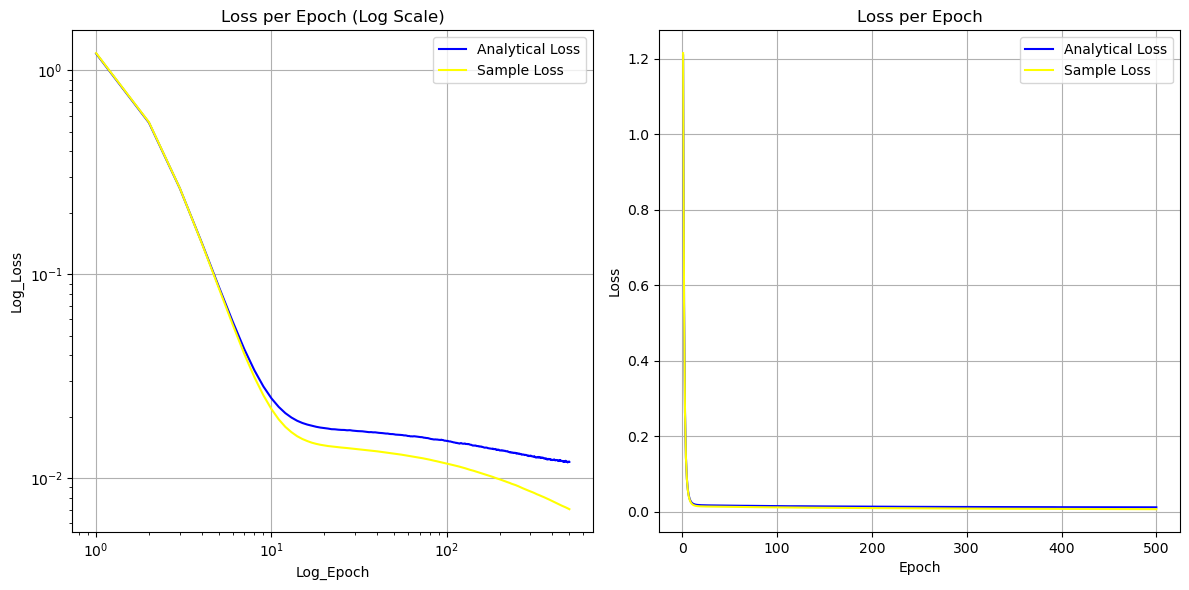

In [125]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# First subplot with log scale for both axes
axs[0].plot(range(1, epoch + 1), true_loss_values, label='Analytical Loss', color='blue')
axs[0].plot(range(1, epoch + 1), empirical_loss_values, label='Sample Loss', color='yellow')
axs[0].set_xlabel('Log_Epoch')
axs[0].set_ylabel('Log_Loss')
axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].set_title('Loss per Epoch (Log Scale)')
axs[0].legend()
axs[0].grid(True)

# Second subplot with linear scale (default)
axs[1].plot(range(1, epoch + 1), true_loss_values, label='Analytical Loss', color='blue')
axs[1].plot(range(1, epoch + 1), empirical_loss_values, label='Sample Loss', color='yellow')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[0].set_yscale("log")
axs[1].set_title('Loss per Epoch')
axs[1].legend()
axs[1].grid(True)

# Display the plot
plt.tight_layout()  # Adjust subplots to fit into the figure area.
plt.show()

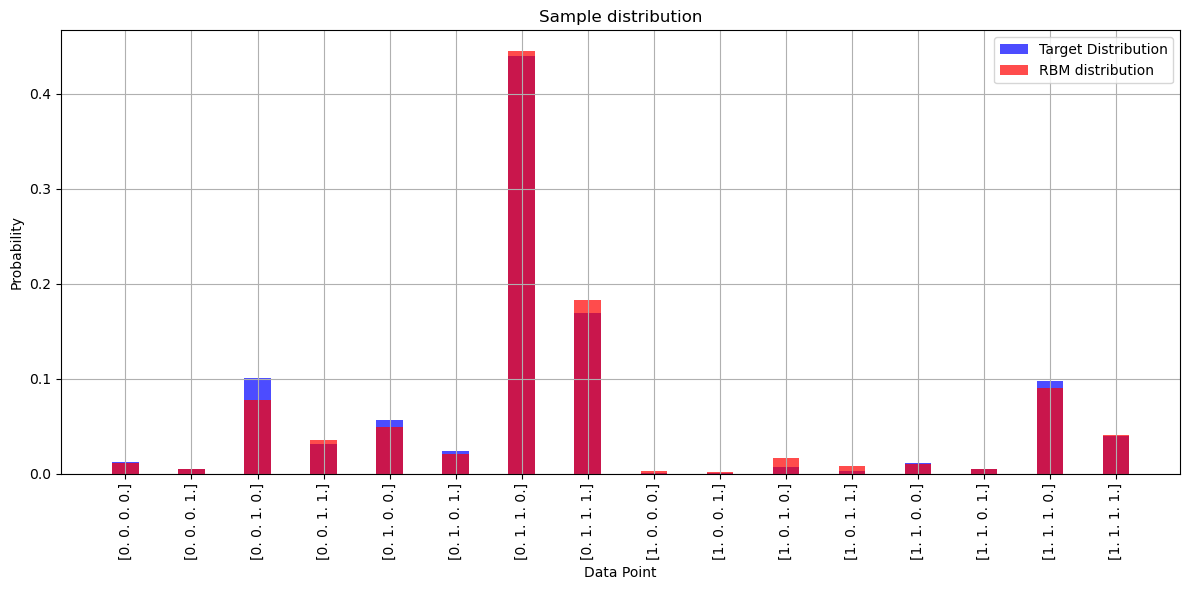

In [127]:
dist3 = rbm.RBM_dist()
plot_histograms1(dist3, dist)

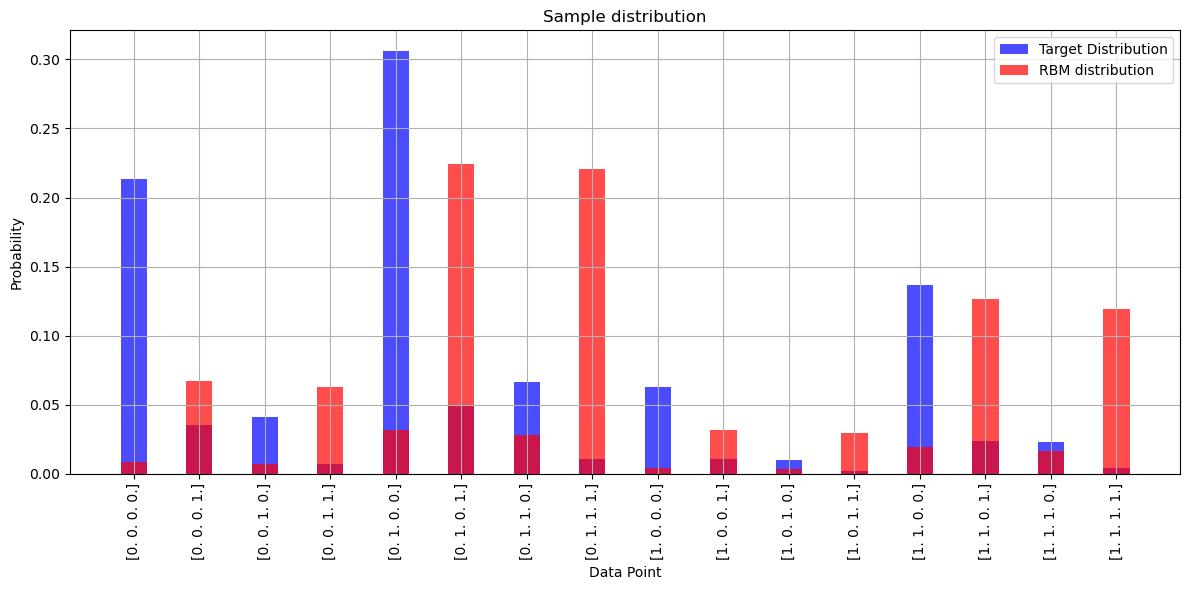

In [14]:
dist3 = rbm3.RBM_dist()
plot_histograms1(dist3, dist)

In [15]:
rbm = rbm3
epoch = 500
lr = 0.1
n_data = num_sample
#min_true_loss = float('inf')  # Initialize minimum true loss to infinity
true_loss_values = []
empirical_loss_values = []
v_size = rbm.n_v
h_size = rbm.n_h

for k in range(epoch):
    g_W = torch.randn(h_size, v_size)
    g_b_v = torch.randn(1, v_size)
    g_b_h = torch.randn(1, h_size)
    
    n_w = 5000
    burn = 1000
    sector_2_sample = rbm.Gibbs_sampler(n_w,burn)
    sector_3_sample = torch.empty((n_w, rbm.n_h))
    sector_1 = 0
    sector_2 = 0
    sector_3 = 0
    for vv in range(n_w):
        sector_3_sample[vv] = rbm.v_to_h(sector_2_sample[vv])
        sector_3_sample_reshaped = sector_3_sample[vv].view(rbm.n_h, 1)  # Reshape to 3x1
        sector_2_sample_reshaped = sector_2_sample[vv].view(1, rbm.n_v)  # Reshape to 1x4
    
        sector_1 = sector_1 + 1/n_w * torch.matmul(sector_3_sample_reshaped, sector_2_sample_reshaped)
        sector_2 = sector_2 + 1/n_w * sector_2_sample[vv]
        sector_3 = sector_3 + 1/n_w * sector_3_sample[vv]
 
    
    for l in range(n_data):
        v = torch.tensor(data[l,:], dtype=torch.float32)
        v = v.unsqueeze(0)
        h = rbm.v_to_h(v)
         
        g_W += torch.matmul(rbm.P_h_1_given_v(v), v)/n_data
        g_b_v += v/n_data
        g_b_h += rbm.P_h_1_given_v(v).t()/n_data
        
    g_W -= sector_1
    g_b_v -= sector_2
    g_b_h -= sector_3
    
    rbm.W = nn.Parameter(rbm.W + lr * g_W)
    rbm.b_v = nn.Parameter(rbm.b_v + lr * g_b_v)
    rbm.b_h = nn.Parameter(rbm.b_h + lr * g_b_h)
    rbm.z = nn.Parameter(rbm.Z())
    
    true_loss = rbm.kl_loss(dist)
    empirical_loss = rbm.kl_loss(sample_dist)
    true_loss_values.append(true_loss.item())  # Convert to Python float
    empirical_loss_values.append(empirical_loss.item())  # Convert to Python float
    
    if (k%10==0):
        true_loss_show = rbm.kl_loss(dist)
        #if (true_loss < min_true_loss):
            #min_true_loss = true_loss
        #else:
            #break
        empirical_loss_show = rbm.kl_loss(sample_dist)
        
        print(f'epoch {k}, Analytical loss {true_loss}')
        print(f'epoch {k}, Sample loss {empirical_loss}')

/var/folders/3n/sd9mh6rx2h5byl5f0955mv840000gn/T/ipykernel_29929/292276433.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v = torch.tensor(data[l,:], dtype=torch.float32)


epoch 0, Analytical loss 1.5838190519860034
epoch 0, Sample loss 1.606656210649757
epoch 10, Analytical loss 0.7002214403857346
epoch 10, Sample loss 0.7202251183660249
epoch 20, Analytical loss 0.16264447740954474
epoch 20, Sample loss 0.17860440737347227
epoch 30, Analytical loss 0.04348300288728517
epoch 30, Sample loss 0.050826275320706424
epoch 40, Analytical loss 0.10322268596937054
epoch 40, Sample loss 0.11780403712945237
epoch 50, Analytical loss 0.026027070273107234
epoch 50, Sample loss 0.027772310599638188
epoch 60, Analytical loss 0.09920170908994408
epoch 60, Sample loss 0.10103702762288273
epoch 70, Analytical loss 0.2572633737126908
epoch 70, Sample loss 0.2608370603720047
epoch 80, Analytical loss 0.14587130799490228
epoch 80, Sample loss 0.1528748825667814
epoch 90, Analytical loss 0.24554378547309352
epoch 90, Sample loss 0.2506924141821264
epoch 100, Analytical loss 0.2351859856372659
epoch 100, Sample loss 0.24296718839985734
epoch 110, Analytical loss 0.1429596958

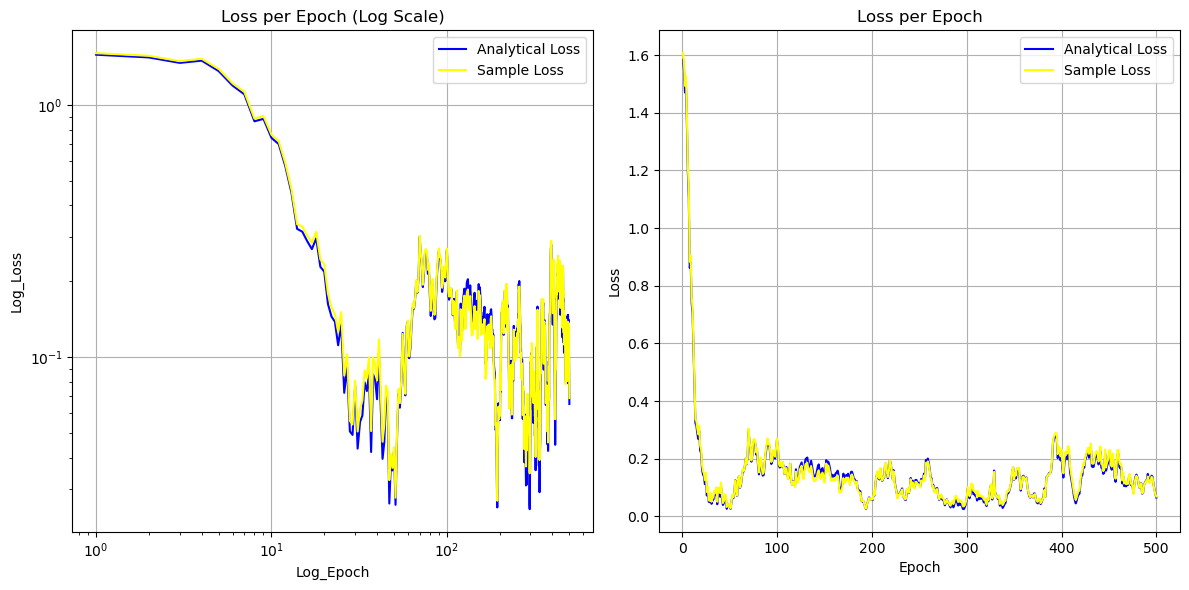

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# First subplot with log scale for both axes
axs[0].plot(range(1, epoch + 1), true_loss_values, label='Analytical Loss', color='blue')
axs[0].plot(range(1, epoch + 1), empirical_loss_values, label='Sample Loss', color='yellow')
axs[0].set_xlabel('Log_Epoch')
axs[0].set_ylabel('Log_Loss')
axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].set_title('Loss per Epoch (Log Scale)')
axs[0].legend()
axs[0].grid(True)

# Second subplot with linear scale (default)
axs[1].plot(range(1, epoch + 1), true_loss_values, label='Analytical Loss', color='blue')
axs[1].plot(range(1, epoch + 1), empirical_loss_values, label='Sample Loss', color='yellow')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Loss per Epoch')
axs[1].legend()
axs[1].grid(True)

# Display the plot
plt.tight_layout()  # Adjust subplots to fit into the figure area.
plt.show()

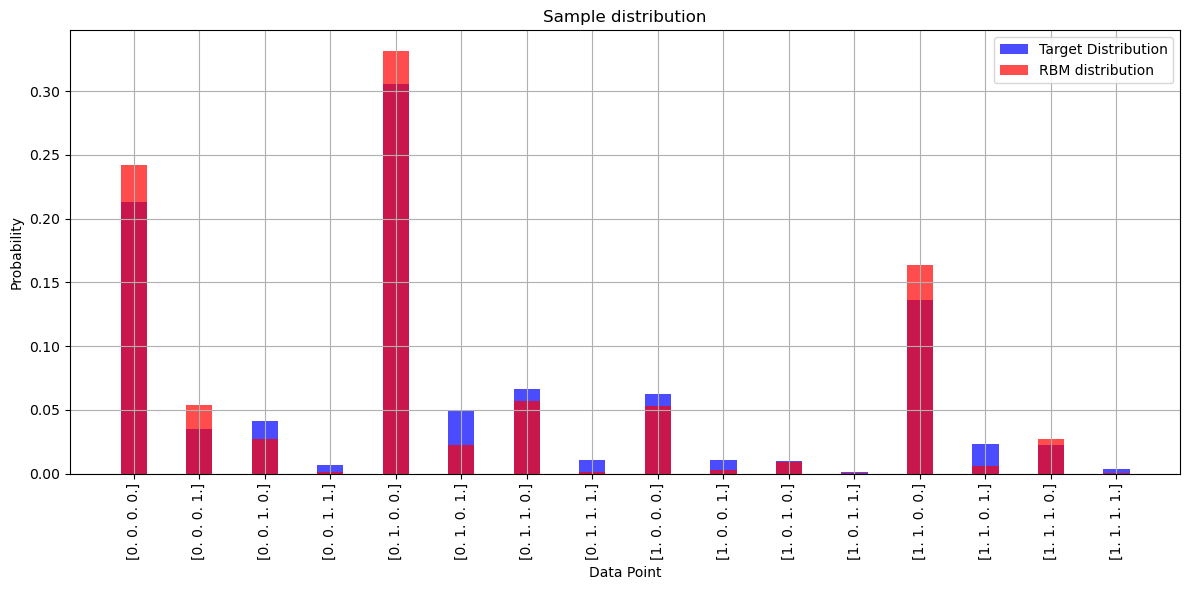

In [17]:
dist4 = rbm.RBM_dist()
plot_histograms1(dist4, dist)